In [312]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Polygon
import numpy as np

from matplotlib import animation, rc
from IPython.display import HTML

In [444]:
n = 5
m = 5
N_agents = 10

In [445]:
CELL_PIXEL_SIZE = 1

ORIENTATIONS = ['N', 'S', 'E', 'W']

CELL_STATE_TO_VALUE = {
    'empty'         : 0,
    'agent'         : 1,
    'goal'          : 2
}

# Map of agent direction indices to vectors
DIR_TO_VEC = {
    'E':np.array((1, 0)),
    'S':np.array((0, 1)),
    'W':np.array((-1, 0)),
    'N':np.array((0, -1))
}


In [446]:
class Cell:
    
    def __init__(self, pos, cap):
        self.pos = pos
        self.cap = cap

In [736]:
class Environment:
    
    def __init__(self, n, m, N_agents):
        assert N_agents < n*m, f'Not enough space available on the grid to place all agents:' +\
            f' {N_agents} agents for {n*m - 1} cells'
        
        self.n = n
        self.m = m
        self.cells = np.empty((n, m), dtype=Cell)
        
        # We instantiate every cells.
        for i in range(n):
            for j in range(m):
                self.cells[i, j] = Cell((i, j), [1])
                
        # We create empty array of Agents.
        self.agents = np.empty((N_agents), dtype=Agent)
        
        # For the moment, we instantiate only one Goal.
        self.goals = [Goal((np.random.randint(n), np.random.randint(m)))]
        
        # We instantiate every Agent at a random position, checking that this position
        # is not already occupied (by an other agent or by a Goal).
        for i in range(N_agents):
            rand_pos = (np.random.randint(n), np.random.randint(m))
            while rand_pos in [g.pos for g in self.goals] or\
            rand_pos in [a.pos for a in self.agents[np.where(self.agents != None)[0]]]:
                rand_pos = (np.random.randint(n), np.random.randint(m))
            self.agents[i] = Agent(rand_pos,
                                   ORIENTATIONS[np.random.randint(len(ORIENTATIONS))], self)
        
    def render(self, fig, ax):
        ax.set_xticks(range(self.n + 1))
        ax.set_yticks(range(self.m + 1))
        img = np.zeros((self.m + 1, self.n + 1, 3), dtype=int) + 255
        for agent in self.agents:
            agent.render(ax)
        for goal in self.goals:
            goal.render(ax)
        ax.imshow(img)
        ax.grid()
        
#         plt.grid()
        
    def random_evolution(self):
        for agent in self.agents:
            if agent.state == 'active':
                agent.perform_random_action()
            if tuple(agent.pos) in [goal.pos for goal in self.goals]:
                agent.state = 'success'
            
    def in_limits(self, pos):
        if pos[0] >= self.n or pos[0] < 0 or pos[1] >= self.m or pos[1] < 0:
            return False
        return True
    
    def allowed_movement(self, pos):
        active_agents = [a.state == 'active' for a in self.agents]
        active_agents = self.agents[np.where(active_agents)[0]]
        if self.in_limits(pos) and (tuple(pos) not in [a.pos for a in active_agents]):
            return True
        return False
    
    def global_observation(self):
        obs = np.zeros((self.n, self.m)) + DIR_TO_VEC['empty']
        for agent in self.agents:
            if agent.state == 'active':
                obs[agent.pos] = DIR_TO_VEC['agent']
        for goal in self.goals:
            obs[goal.pos] = DIR_TO_VEC['goal']
            
        return obs
        

In [760]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed,  hidsize1 = 128, hidsize2 = 64):
        super(QNetwork, self).__init__()

        self.fc1_val = nn.Linear(state_size, hidsize1)
        self.fc2_val = nn.Linear(hidsize1, hidsize2)
        self.fc3_val = nn.Linear(hidsize2, 1)

        self.fc1_adv = nn.Linear(state_size, hidsize1)
        self.fc2_adv = nn.Linear(hidsize1, hidsize2)
        self.fc3_adv = nn.Linear(hidsize2, action_size)


    def forward(self, x):

        val = F.relu(self.fc1_val(x))
        val = F.relu(self.fc2_val(val))
        val = self.fc3_val(val)

        # advantage calculation
        adv = F.relu(self.fc1_adv(x))
        adv = F.relu(self.fc2_adv(adv))
        adv = self.fc3_adv(adv)
        return val + adv - adv.mean()

In [764]:
import numpy as np
import random
from collections import namedtuple, deque

import torch
import torch.nn.functional as F
import torch.optim as optim
import copy
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 256        # minibatch size
GAMMA = 0.99            # discount factor 0.99
TAU = 1e-3              # for soft update of target parameters
LR = 1.e-5# learning rate 4
UPDATE_EVERY = 4        # how often to update the network
double_dqn = True       # If using double dqn algorithm
input_channels = 5      # Number of Input channels

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print(device)

class Agent():
    """Interacts with and learns from the environment."""
    
    
    def __init__(self, state_size, action_size, net_type, seed,double_dqn = True):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.version = net_type
        self.double_dqn = double_dqn
        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = copy.deepcopy(self.qnetwork_local)

        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
        
    def load(self):
        self.qnetwork_target = copy.deepcopy(self.qnetwork_local)
        return

    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):

        """Update value parameters using given batch of experience tuples.
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)


        if self.double_dqn:
        # Double DQN
            q_best_action = self.qnetwork_local(next_states).max(1)[1]
            Q_targets_next = self.qnetwork_target(next_states).gather(1, q_best_action.unsqueeze(-1))
        else:
        # DQN
            Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(-1)

            # Compute Q targets for current states

        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))



        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

cpu


In [762]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(np.expand_dims(state,0), action, reward, np.expand_dims(next_state,0), done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [724]:
class Agent:
    
    def __init__(self, pos, orientation, env):
        self.pos = pos
        self.orientation = orientation
        self.env = env
        self.state = 'active'
        
    def render(self, r):
        pos = self.pos
        if self.orientation == 'S':
            r.add_patch(Polygon([[pos[0]*CELL_PIXEL_SIZE, pos[1]*CELL_PIXEL_SIZE],
                             [(pos[0]+1)*CELL_PIXEL_SIZE, pos[1]*CELL_PIXEL_SIZE],
                             [(pos[0]+0.5)*CELL_PIXEL_SIZE, (pos[1]+1)*CELL_PIXEL_SIZE]], color='orange'))
        elif self.orientation == 'N':
            r.add_patch(Polygon([[pos[0]*CELL_PIXEL_SIZE, (pos[1]+1)*CELL_PIXEL_SIZE],
                             [(pos[0]+1)*CELL_PIXEL_SIZE, (pos[1]+1)*CELL_PIXEL_SIZE],
                             [(pos[0]+0.5)*CELL_PIXEL_SIZE, (pos[1])*CELL_PIXEL_SIZE]], color='orange'))
        elif self.orientation == 'E':
            r.add_patch(Polygon([[pos[0]*CELL_PIXEL_SIZE, pos[1]*CELL_PIXEL_SIZE],
                             [pos[0]*CELL_PIXEL_SIZE, (pos[1]+1)*CELL_PIXEL_SIZE],
                             [(pos[0]+1)*CELL_PIXEL_SIZE, (pos[1]+0.5)*CELL_PIXEL_SIZE]], color='orange'))
        else:
            r.add_patch(Polygon([[(pos[0]+1)*CELL_PIXEL_SIZE, pos[1]*CELL_PIXEL_SIZE],
                             [(pos[0]+1)*CELL_PIXEL_SIZE, (pos[1]+1)*CELL_PIXEL_SIZE],
                             [(pos[0])*CELL_PIXEL_SIZE, (pos[1]+0.5)*CELL_PIXEL_SIZE]], color='orange'))
            
    def change_orientation(self, new_orientation):
        self.orientation = new_orientation
    
    def move_forward(self):
        if env.allowed_movement(self.pos + DIR_TO_VEC[self.orientation]):
            self.pos += DIR_TO_VEC[self.orientation]
            self.pos = tuple(self.pos)
        
    def perform_random_action(self):
        r = np.random.randint(3)
        if r == 0:
            self.change_orientation(ORIENTATIONS[np.random.randint(len(ORIENTATIONS))])
        elif r == 1:
            self.move_forward()

In [725]:
class Goal:
    
    def __init__(self, pos):
        self.pos = pos
        
    def render(self, r):
        pos = self.pos
        r.add_patch(Rectangle((pos[0] * CELL_PIXEL_SIZE, pos[1] * CELL_PIXEL_SIZE),
                              CELL_PIXEL_SIZE, CELL_PIXEL_SIZE, color='green'))

In [749]:
def train(seed = None):
    if seed is not None:
        np.random.seed(seed)
        
    env = Environment(7, 7, 1)
    

In [752]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.categorical import Categorical

def initialize_parameters(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0, 1)
        m.weight.data *= 1 / torch.sqrt(m.weight.data.pow(2).sum(1, keepdim=True))
        if m.bias is not None:
            m.bias.data.fill_(0)
            
class ACModel(nn.Module):
    
    def __init__(self, env, action_space):
        super().__init__()
        
        self.image_conv = nn.Sequential(
            nn.Conv2d(3, 16, (2, 2)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(16, 32, (2, 2)),
            nn.ReLU(),
            nn.Conv2d(32, 64, (2, 2)),
            nn.ReLU())
        
        n = env.n
        m = env.m
        self.image_embedding_size = ((n-1)//2-2)*((m-1)//2-2)*64
        
        # Seems to be from embedding size to action space size
        self.actor = nn.Sequential(
                nn.Linear(self.image_embedding_size, 64),
                nn.Tanh(),
                nn.Linear(64, action_space.n))
        
        # Define critic's model
        self.critic = nn.Sequential(
            nn.Linear(self.image_embedding_size, 64),
            nn.Tanh(),
            nn.Linear(64, 1))
        
        # Initialize parameters correctly
        self.apply(initialize_parameters)
        
    def forward(self, obs):
        x = torch.transpose(torch.transpose(obs.image, 1, 3), 2, 3)
        x = self.image_conv(x)
        x = x.reshape(x.shape[0], -1)
        
        embedding = x

        x = self.actor(embedding)
        dist = Categorical(logits=F.log_softmax(x, dim=1))

        x = self.critic(embedding)
        value = x.squeeze(1)

        return dist, value


In [756]:
class A2CAlgo:
    """The class for the Advantage Actor-Critic algorithm."""

    def __init__(self, env, acmodel, discount=0.99, lr=7e-4, gae_lambda=0.95,
                 entropy_coef=0.01, value_loss_coef=0.5, max_grad_norm=0.5, recurrence=4,
                 rmsprop_alpha=0.99, rmsprop_eps=1e-5, preprocess_obss=None, reshape_reward=None):
        
        num_frames_per_proc = 8
        
        self.env = env
        self.acmodel = acmodel
        self.acmodel.train()
        self.num_frames_per_proc = num_frames_per_proc
        self.discount = discount
        self.lr = lr
        self.gae_lambda = gae_lambda
        self.entropy_coef = entropy_coef
        self.value_loss_coef = value_loss_coef
        self.max_grad_norm = max_grad_norm
        self.recurrence = recurrence
        self.preprocess_obss = preprocess_obss or default_preprocess_obss
        self.reshape_reward = reshape_reward

        # Store helpers values

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.num_procs = 1
        self.num_frames = self.num_frames_per_proc
        
        shape = self.num_frames_per_proc
        
        self.obs = self.env.reset()
        self.obss = [None]*(shape)
        if self.acmodel.recurrent:
            self.memory = torch.zeros(self.acmodel.memory_size, device=self.device)
            self.memories = torch.zeros(shape, self.acmodel.memory_size, device=self.device)
            
        self.mask = torch.ones(shape, device=self.device)
        self.masks = torch.zeros(shape, device=self.device)
        self.actions = torch.zeros(shape, device=self.device, dtype=torch.int)
        self.values = torch.zeros(shape, device=self.device)
        self.rewards = torch.zeros(shape, device=self.device)
        self.advantages = torch.zeros(shape, device=self.device)
        self.log_probs = torch.zeros(shape, device=self.device)
        
        self.log_episode_return = torch.zeros(device=self.device)
        self.log_episode_reshaped_return = torch.zeros(device=self.device)
        self.log_episode_num_frames = torch.zeros(device=self.device)

        self.log_done_counter = 0
        self.log_return = 0
        self.log_reshaped_return = 0
        self.log_num_frames = 0
        
        self.optimizer = torch.optim.RMSprop(self.acmodel.parameters(), lr,
                                                alpha=rmsprop_alpha, eps=rmsprop_eps)
        
        
    def collect_experiences(self):
        exps, logs = self.collect_experiences()
        inds = self._get_starting_indexes()

In [755]:
s = 1
torch.zeros(*s)

TypeError: zeros() argument after * must be an iterable, not int

In [748]:
((9-1)//2-2)*((9-1)//2-2)*64

256

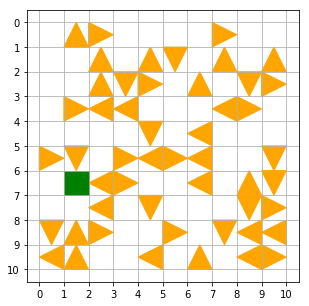

In [740]:

env = Environment(10, 10, 50)
fig, ax = plt.subplots(1, 1, figsize=[5, 5])
# for i in range(200):
#     env.random_evolution()
env.render(fig, ax)

In [758]:
def simulate(i):
    env.random_evolution()
    ax.clear()
    env.render(fig, ax)
    return (ax,)

anim = animation.FuncAnimation(fig, simulate, init_func=env.render(fig, ax),
                               frames=100, interval=200, 
                               blit=False)


HTML(anim.to_jshtml())

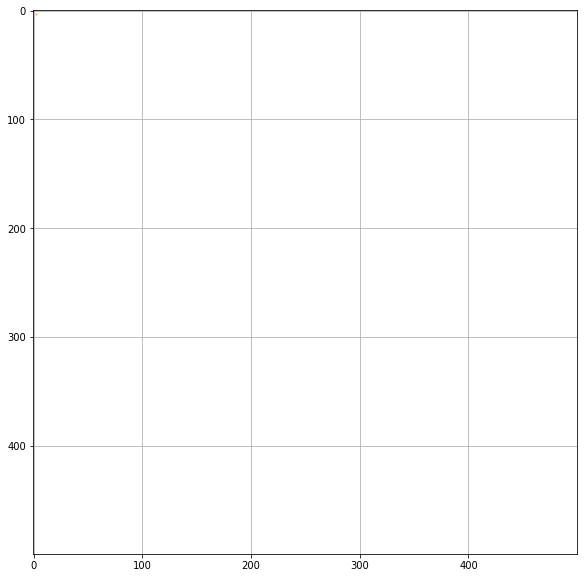

In [499]:
img = np.zeros((500, 500, 3), dtype=int) + 255
i = 2
j = 3
pos = (i,j)

# img[j*100: (j+1)*100, i*100: (i+1)*100, 2] = 0
# img[j*100: (j+1)*100, i*100: (i+1)*100, 1] = 0
_, fig = plt.subplots(1,1,figsize=[10,10])

plt.imshow(img)
# fig.add_patch(Rectangle((i*100, j*100), 100, 100, color='green'))
fig.add_patch(Polygon([[(pos[0]+1)*CELL_PIXEL_SIZE, pos[1]*CELL_PIXEL_SIZE],
                             [(pos[0]+1)*CELL_PIXEL_SIZE, (pos[1]+1)*CELL_PIXEL_SIZE],
                             [(pos[0])*CELL_PIXEL_SIZE, (pos[1]+0.5)*CELL_PIXEL_SIZE]], color='orange'))
# fig.axes.get_xaxis().set_visible(False)
# fig.axes.get_yaxis().set_visible(False)
# plt.Polygon.draw()
plt.grid()

In [9]:
a = numpy.empty((n, m), dtype=Cell)

In [18]:
connections = np.zeros((4,5))
connections[:,0] = 1
connections

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [8]:
Cell((2,3), [1, 0], [1,0,0,0,0])